In [1]:
# Checklist:
# AWS emr-5.29.0
# MASTER r5d.8xlarge 1x, no EBS
# CORE r5d.8xlarge 4x, no EBS
# Custom bootstrap action: s3://ydatazian/bootstrap.sh
# Allow ssh in master node security group

In [2]:
import tqdm.notebook as tqdm
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('max_colwidth', 120 * 10)
pd.set_option('display.width', 120)

# SparkSession

https://spark.apache.org/docs/2.4.4/api/python/pyspark.html

https://spark.apache.org/docs/2.4.4/api/python/pyspark.sql.html

In [3]:
import findspark
findspark.init()

import spark_utils
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
sc = SparkContext("yarn", "My App", conf=spark_utils.get_spark_conf())
se = SparkSession(sc)
spark_utils.print_ui_links()

NameNode: http://ec2-54-144-209-69.compute-1.amazonaws.com:50070
YARN: http://ec2-54-144-209-69.compute-1.amazonaws.com:8088
Spark UI: http://ec2-54-144-209-69.compute-1.amazonaws.com:20888/proxy/application_1591527324814_0002


# Register all tables for sql queries

In [4]:
from IPython.display import display
tables = ["clicks_test", "clicks_train", 
          "documents_categories", "documents_entities", "documents_meta", "documents_topics", 
          "events", "page_views", "page_views_sample", "promoted_content"]
for name in tqdm.tqdm(tables):
    df = se.read.parquet("s3://ydatazian/{}.parquet".format(name))
    df.registerTempTable(name)
    print(name)
    display(df.limit(3).toPandas())

clicks_test


,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754


clicks_train


,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1


documents_categories


,document_id,category_id,confidence_level
0,1595802,1611,0.92
1,1595802,1610,0.07
2,1524246,1807,0.92


documents_entities


,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865314504701
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399113728441297
2,1524246,839907a972930b17b125eb0247898412,0.392095749652966


documents_meta


,document_id,source_id,publisher_id,publish_time
0,1595802,1,603,2016-06-05 00:00:00
1,1524246,1,603,2016-05-26 11:00:00
2,1617787,1,603,2016-05-27 00:00:00


documents_topics


,document_id,topic_id,confidence_level
0,1595802,140,0.0731131601068925
1,1595802,16,0.0594164867373976
2,1595802,143,0.0454207537554526


events


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505


page_views


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


page_views_sample


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


promoted_content


,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7


# All clicks

In [5]:
%%time
! hdfs dfs -rm -r /clicks.parquet
se.sql("""
select *
from 
    (
    select 
        *,
        true as is_train
    from clicks_train
    )
    union
    (
    select 
        *,
        "0" as clicked,
        false as is_train
    from clicks_test
    )
""").write.parquet("/clicks.parquet")
se.read.parquet("/clicks.parquet").registerTempTable("clicks")

rm: `/clicks.parquet': No such file or directory
CPU times: user 27.9 ms, sys: 5.18 ms, total: 33.1 ms
Wall time: 35.6 s


In [6]:
se.table("clicks").show(5)

+----------+------+-------+--------+
|display_id| ad_id|clicked|is_train|
+----------+------+-------+--------+
|   4612607|145930|      0|    true|
|   4612610| 78408|      0|    true|
|   4612729|147700|      1|    true|
|   4612742| 26711|      0|    true|
|   4612787|347925|      0|    true|
+----------+------+-------+--------+
only showing top 5 rows



# Ad_id features

In [7]:
%%time
! hdfs dfs -rm -r /ad_entities.parquet
se.sql("""
select 
    pc.ad_id,
    collect_list(struct(de.entity_id, cast(de.confidence_level as float) as confidence_level)) as ad_entities
from promoted_content as pc join documents_entities as de on pc.document_id = de.document_id
group by pc.ad_id
""").write.parquet("/ad_entities.parquet")
se.read.parquet("/ad_entities.parquet").registerTempTable("ad_entities")

rm: `/ad_entities.parquet': No such file or directory
CPU times: user 15.3 ms, sys: 11.9 ms, total: 27.2 ms
Wall time: 9.23 s


In [8]:
se.table("ad_entities").limit(5).toPandas()

,ad_id,ad_entities
0,100142,"[(98bf11f29dd0160f58d870c0c7c6f07f, 0.226028174161911)]"
1,100786,"[(810e7275c37b02ca9a5f9d9d231026a5, 0.4200795590877533), (8324e76d44852e22856240b6d1aef8ed, 0.35910481214523315), (d551b0d2feb1f8a89239bccddd1165d8, 0.3047851026058197), (b3a036f452490cf3f66b3e9dd26e45c8, 0.2971663773059845), (1834eb4deaf946bebcd2f6a3e21e7261, 0.28737881779670715), (10fc9950c0115ec50bda13e11c97371b, 0.23719897866249084)]"
2,100927,"[(131f700eabaa8f979501bfab7e1292e9, 0.5807134509086609), (b7da2a65e94bb207d22d2f0a4160be8f, 0.487897664308548), (ef598e7005c5ce1415fe6d8c7b40b6fc, 0.2968069016933441), (16eab421b5c6234b361fbb4e165a5748, 0.2683892548084259), (88c79cc2ad4990c2157c9e87193ad9fd, 0.2671460807323456)]"
3,100956,"[(328584ed6b068951678fa66d0d555aa1, 0.4431387782096863)]"
4,101136,"[(a76d913c10865c3b5c2b2fbc194af0bc, 0.8150035738945007)]"


In [9]:
se.table("ad_entities").printSchema()

root
 |-- ad_id: string (nullable = true)
 |-- ad_entities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- entity_id: string (nullable = true)
 |    |    |-- confidence_level: float (nullable = true)



In [10]:
%%time
! hdfs dfs -rm -r /ad_topics.parquet
se.sql("""
select 
    pc.ad_id,
    collect_list(struct(dt.topic_id, cast(dt.confidence_level as float) as confidence_level)) as ad_topics
from promoted_content as pc join documents_topics as dt on pc.document_id = dt.document_id
group by pc.ad_id
""").write.parquet("/ad_topics.parquet")
se.read.parquet("/ad_topics.parquet").registerTempTable("ad_topics")

rm: `/ad_topics.parquet': No such file or directory
CPU times: user 15.5 ms, sys: 10.3 ms, total: 25.9 ms
Wall time: 8.34 s


In [11]:
se.table("ad_topics").limit(5).toPandas()

,ad_id,ad_topics
0,100142,"[(181, 0.3299613893032074)]"
1,100786,"[(249, 0.1530769318342209), (32, 0.08436058461666107), (297, 0.0451713502407074), (192, 0.03516631945967674), (85, 0.01974184438586235), (10, 0.01973884180188179), (181, 0.018032323569059372), (65, 0.012276466004550457), (146, 0.011644311249256134), (219, 0.0092721376568079)]"
2,100841,"[(92, 0.038239285349845886), (8, 0.029061492532491684), (100, 0.0285784974694252), (174, 0.019483203068375587), (258, 0.015252185054123402)]"
3,100927,"[(269, 0.34830808639526367)]"
4,100956,"[(16, 0.07634807378053665), (85, 0.0463380366563797), (249, 0.030323520302772522), (92, 0.018669400364160538), (17, 0.014306258410215378), (154, 0.010022616013884544), (258, 0.008142800070345402)]"


In [12]:
se.table("ad_topics").printSchema()

root
 |-- ad_id: string (nullable = true)
 |-- ad_topics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- topic_id: string (nullable = true)
 |    |    |-- confidence_level: float (nullable = true)



# Display_id features (based on page_views)

In [13]:
# 3% of users have display events with clicks (organic click rate)
print(se.sql("select distinct(uuid) from page_views").count())
print(se.sql("select distinct(uuid) from events").count())

717506889
19794967


In [14]:
# display_ids are unique
print(se.table('events').count())
print(se.sql('select distinct(display_id) from events').count())

23120126
23120126


In [15]:
# all display_ids are split 73% train / 27% test
print(se.sql('select distinct(display_id) from clicks_train').count())
print(se.sql('select distinct(display_id) from clicks_test').count())

16874593
6245533


1.0
92.0
CPU times: user 80.1 ms, sys: 0 ns, total: 80.1 ms
Wall time: 26.8 s


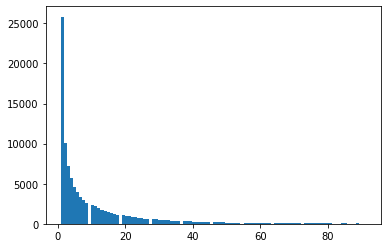

In [16]:
%%time
# page views per user
sizes = se.sql("""
select 
    uuid,
    count(1) as s
from page_views
group by uuid
limit 100000
""").rdd.map(lambda x: x.s).collect()
sizes = np.array(sizes)
print(np.percentile(sizes, 1))
print(np.percentile(sizes, 99))
sizes = sizes[sizes < np.percentile(sizes, 99)]
_ = plt.hist(sizes, bins=100)

In [17]:
%%time
! hdfs dfs -rm -r /display_topics.parquet
se.sql("""
select 
    tmp.display_id,
    collect_list(struct(tmp.topic_id, tmp.confidence_level)) as display_topics
from
    (
    select 
        e.display_id,
        dt.topic_id,
        sum(cast(dt.confidence_level as float)) as confidence_level
    from events as e 
        join page_views as pv on e.uuid = pv.uuid
        join documents_topics as dt on pv.document_id = dt.document_id
    group by e.display_id, dt.topic_id
    ) as tmp
group by tmp.display_id
""").write.parquet("/display_topics.parquet")
se.read.parquet("/display_topics.parquet").registerTempTable("display_topics")

rm: `/display_topics.parquet': No such file or directory
CPU times: user 19 ms, sys: 12.1 ms, total: 31 ms
Wall time: 1min 7s


In [18]:
se.table('display_topics').limit(5).toPandas()

,display_id,display_topics
0,10000108,"[(226, 0.01831120066344738), (24, 0.03409966453909874), (23, 0.011111683212220669), (36, 0.011638008058071136), (285, 0.05787719041109085)]"
1,10000172,"[(216, 0.030948465690016747), (165, 0.011910940520465374), (117, 0.009993643499910831), (296, 0.0131217110902071), (43, 0.07451725751161575), (252, 0.04121653363108635), (265, 0.017551081255078316), (65, 0.01133553497493267), (250, 0.026951756328344345), (271, 0.00905686430633068), (291, 0.011835604906082153), (140, 0.09547334164381027), (8, 0.06744621694087982)]"
2,10000304,"[(8, 0.3981176484376192), (286, 0.011767380870878696), (219, 0.008387570269405842), (53, 0.010009721852838993), (215, 0.00808124803006649), (86, 0.028774918988347054), (47, 0.035426488146185875), (92, 0.030851103365421295), (217, 0.04047518130391836), (9, 0.00835688691586256), (213, 0.008168152533471584), (233, 0.010877534747123718), (192, 0.04684021882712841), (148, 0.03774159401655197), (250, 0.01871490851044655), (165, 0.01388646475970745), (258, 0.048923324793577194), (156, 0.008396882563829422), (134, 0.008266095072031021), (181, 0.035898368805646896), (179, 0.04806268401443958), (87, 0.03606506623327732), (216, 0.008100329898297787), (160, 0.6086612334474921), (254, 0.08038891851902008), (173, 0.28092633187770844), (10, 0.16390062309801579), (43, 0.035802148282527924), (281, 0.0649278499186039), (234, 0.010964683257043362), (265, 0.0391863826662302), (16, 0.06784232892096043), (239, 0.009890459477901459), (110, 0.008071144111454487), (242, 0.010148745961487293), (284, 0.013923902995884418), (89, 0.029356347396969795), (17, 0.00829986296594143), (25, 0.09550920873880386), (19, 0.010221339762210846), (82, 0.035799325443804264), (136, 0.05665453150868416), (168, 0.0085073281..."
3,10000454,"[(66, 0.10618241131305695), (214, 0.11549584567546844)]"
4,10000472,"[(66, 0.3372142016887665), (153, 0.10199250280857086), (8, 0.07532715797424316), (288, 0.22514894604682922), (294, 0.10637307912111282), (43, 0.046946462243795395), (131, 0.0251818485558033), (170, 0.06858696043491364), (16, 0.04280128329992294), (162, 0.009045521728694439), (240, 0.5298454761505127), (172, 0.00802045688033104), (12, 0.008581609465181828), (174, 0.09856970608234406), (107, 0.028440061956644058), (252, 0.5444167256355286), (216, 0.03410104662179947), (214, 0.24369288980960846), (211, 0.03875367343425751), (93, 0.023324333131313324), (19, 0.020135674625635147), (176, 0.020381975919008255)]"


In [19]:
%%time
! hdfs dfs -rm -r /display_views.parquet
se.sql("""
select 
    e.display_id,
    collect_list(pv.document_id) as views
from events as e 
    join page_views as pv on e.uuid = pv.uuid
group by e.display_id
""").write.parquet("/display_views.parquet")
se.read.parquet("/display_views.parquet").registerTempTable("display_views")

rm: `/display_views.parquet': No such file or directory
CPU times: user 21.2 ms, sys: 7.24 ms, total: 28.5 ms
Wall time: 30.7 s


In [20]:
se.table('display_views').limit(5).toPandas()

,display_id,views
0,10000108,[1126487]
1,10000172,[1233989]
2,10000304,"[230213, 1077294, 1077398, 229897, 1075288, 1088232, 654481, 1077376, 1077622, 1086036, 1075290, 1077542, 1077407, 1077663]"
3,10000454,"[2410517, 2353341]"
4,10000472,"[1096452, 2350764, 1429540, 1479883, 2398538, 1179111, 2851366, 1179111, 2791394, 2206674]"


In [21]:
! hdfs dfs -du -s -h "/*"

39.8 M  /ad_entities.parquet
13.9 M  /ad_topics.parquet
888.2 M  /clicks.parquet
3.7 G  /display_topics.parquet
1.8 G  /display_views.parquet
0  /tmp
220.5 M  /user
474.9 K  /var


# Prepare dataset for VW

We will predict a *click* based on:
- ad_id
- document_id
- campaign_id
- advertiser_id
- ad_topics
- ad_entities
- display_topics
- display_views

In [22]:
se.table("clicks").show(3)

+----------+------+-------+--------+
|display_id| ad_id|clicked|is_train|
+----------+------+-------+--------+
|   4612607|145930|      0|    true|
|   4612610| 78408|      0|    true|
|   4612729|147700|      1|    true|
+----------+------+-------+--------+
only showing top 3 rows



In [33]:
%%time
# join everything
! hdfs dfs -rm -r /features.parquet
se.sql("""
select 
    c.*,
    pc.document_id,
    pc.campaign_id,
    pc.advertiser_id,
    at.ad_topics,
    ae.ad_entities,
    dt.display_topics,
    dv.views,
    e.document_id as display_document_id,
    split(e.geo_location, '>')[0] as country, 
    split(e.geo_location, '>')[1] as state,
    split(e.geo_location, '>')[2] as DMA,
    dayofweek(to_date(from_unixtime(e.timestamp + 1465876799998,'YYYY-MM-dd'))) as day_of_week,
    e.platform,
    hour(from_unixtime(e.timestamp + 1465876799998)) as hour_in_day,
    m.source_id,
    m.publisher_id,
    dayofweek(to_date(m.publish_time)) as publish_day_of_week,
    hour(to_timestamp(m.publish_time)) as publish_hour
from clicks as c 
    left join promoted_content as pc on c.ad_id = pc.ad_id
    left join ad_topics as at        on c.ad_id = at.ad_id
    left join ad_entities as ae      on c.ad_id = ae.ad_id
    left join display_topics as dt   on c.display_id = dt.display_id
    left join display_views as dv    on c.display_id = dv.display_id
    left join events as e on e.display_id = c.display_id
    left join documents_meta as m on m.document_id = e.document_id
""").write.parquet("/features.parquet")
se.read.parquet("/features.parquet").registerTempTable('features')

Deleted /features.parquet
CPU times: user 24.7 ms, sys: 8.37 ms, total: 33 ms
Wall time: 1min 49s


In [34]:
se.table('features').limit(10).toPandas()

,display_id,ad_id,clicked,is_train,document_id,campaign_id,advertiser_id,ad_topics,ad_entities,display_topics,...,country,state,DMA,day_of_week,platform,hour_in_day,source_id,publisher_id,publish_day_of_week,publish_hour
0,12873428,131051,0,True,1260918,16261,2594,"[(285, 0.27981138229370117)]","[(e9fb4cd4ccfb2b368b80c81c6e361404, 0.9245238900184631)]","[(235, 0.039750855416059494), (89, 0.06759750843048096), (198, 0.026800742372870445), (16, 0.021410731598734856), (248, 0.010304695926606655), (20, 0.060568951070308685), (140, 0.14258135855197906), (138, 0.08946835249662399), (238, 0.024729739874601364), (285, 0.03563092276453972), (194, 0.20825890079140663), (184, 0.031643666326999664), (160, 0.15520574152469635), (66, 0.023279905319213867), (281, 0.008753185160458088), (143, 0.0881824716925621), (57, 0.012920819222927094), (43, 0.01465380098670721)]",...,GB,None,None,None,3,None,890,522,3,8
1,12873428,406558,0,True,777739,30823,3728,"[(2, 0.02897670306265354)]","[(7b38fb685b3add89cebb5bba2feba79b, 0.9770570397377014)]","[(235, 0.039750855416059494), (89, 0.06759750843048096), (198, 0.026800742372870445), (16, 0.021410731598734856), (248, 0.010304695926606655), (20, 0.060568951070308685), (140, 0.14258135855197906), (138, 0.08946835249662399), (238, 0.024729739874601364), (285, 0.03563092276453972), (194, 0.20825890079140663), (184, 0.031643666326999664), (160, 0.15520574152469635), (66, 0.023279905319213867), (281, 0.008753185160458088), (143, 0.0881824716925621), (57, 0.012920819222927094), (43, 0.01465380098670721)]",...,GB,None,None,None,3,None,890,522,3,8
2,12873428,489368,0,True,2309382,16261,2594,"[(26, 0.07046321779489517), (143, 0.053482454270124435), (44, 0.039598967880010605), (247, 0.03914680331945419), (142, 0.01339764054864645)]","[(e9fb4cd4ccfb2b368b80c81c6e361404, 0.921190083026886)]","[(235, 0.039750855416059494), (89, 0.06759750843048096), (198, 0.026800742372870445), (16, 0.021410731598734856), (248, 0.010304695926606655), (20, 0.060568951070308685), (140, 0.14258135855197906), (138, 0.08946835249662399), (238, 0.024729739874601364), (285, 0.03563092276453972), (194, 0.20825890079140663), (184, 0.031643666326999664), (160, 0.15520574152469635), (66, 0.023279905319213867), (281, 0.008753185160458088), (143, 0.0881824716925621), (57, 0.012920819222927094), (43, 0.01465380098670721)]",...,GB,None,None,None,3,None,890,522,3,8
3,12873428,160698,0,True,1400277,16162,185,"[(33, 0.06512783467769623), (236, 0.06510519236326218)]","[(4bfa9c9df93858e569181a3a948c6a65, 0.20303639769554138), (e4bcabf3729ff7c1db2c5fa626ae3304, 0.20155403017997742)]","[(235, 0.039750855416059494), (89, 0.06759750843048096), (198, 0.026800742372870445), (16, 0.021410731598734856), (248, 0.010304695926606655), (20, 0.060568951070308685), (140, 0.14258135855197906), (138, 0.08946835249662399), (238, 0.024729739874601364), (285, 0.03563092276453972), (194, 0.20825890079140663), (184, 0.031643666326999664), (160, 0.15520574152469635), (66, 0.023279905319213867), (281, 0.008753185160458088), (143, 0.0881824716925621), (57, 0.012920819222927094), (43, 0.01465380098670721)]",...,GB,None,None,None,3,None,890,522,3,8
4,12873428,134263,1,True,1300757,16162,185,"[(172, 0.022397704422473907), (24, 0.015290997922420502), (285, 0.01293039321899414), (148, 0.009189638309180737), (197, 0.009175166487693787), (213, 0.009062024764716625), (230, 0.009052719920873642), (40, 0.00891966838389635)]","[(fdd12b5412150aa2708d221a227d3fac, 0.8454307913780212), (c78ba28c8570a4bf2e2e961125f09bb4, 0.2937357425689697), (c2fc7fcd857516420db7f162090ffa53, 0.29333817958831787)]","[(235, 0.039750855416059494), (89, 0.06759750843048096), (198, 0.026800742372870445), (16, 0.021410731598734856), (248, 0.010304695926606655), (20, 0.060568951070308685), (140, 0.14258135855197906), (138, 0.08946835249662399), (238, 0.024729739874601364), (285, 0.03563092276453972), (194, 0.20825890079140663), (184, 0.031643666326999664), (160, 0.15520574152469635), (66, 0.023279905319213867), (28

In [35]:
# Format: [Label] [Importance] [Base] [Tag]|Namespace Features |Namespace Features ... |Namespace Features
# https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Input-format
def vw_row_mapper(row):
    clicked = '1' if row.clicked == '1' else '-1'
    # item features
    item_features = "|a "
    item_features += "ad_id_{}".format(row.ad_id) + " "
    item_features += "document_id_{}".format(row.document_id) + " "
    item_features += "campaign_id_{}".format(row.campaign_id) + " "
    item_features += "advertiser_id_{}".format(row.advertiser_id) + " "
    if row.ad_topics:
        s = sum(v for k, v in row.ad_topics)
        item_features += " ".join("ad_topic_{}:{:.6}".format(k, v / s) for k, v in row.ad_topics) + " "
    if row.ad_entities:
        s = sum(v for k, v in row.ad_entities)
        item_features += " ".join("ad_entity_{}:{:.6}".format(k, v / s) for k, v in row.ad_entities) + " "
    # display features
    display_features = "|d "
    display_features += "display_document_id_{}".format(row.display_document_id) + " "
    display_features += "country_{}".format(row.country) + " "
    display_features += "state_{}".format(row.state) + " "
    display_features += "DMA_{}".format(row.DMA) + " "
    display_features += "day_of_week_{}".format(row.day_of_week) + " "
    display_features += "platform_{}".format(row.platform) + " "
    display_features += "hour_in_day_{}".format(row.hour_in_day) + " "
    display_features += "source_id_{}".format(row.source_id) + " "
    display_features += "publisher_id_{}".format(row.publisher_id) + " "
    display_features += "publish_day_of_week_{}".format(row.publish_day_of_week) + " "
    display_features += "publish_hour_{}".format(row.publish_hour) + " "
    if row.display_topics:
        s = sum(v for k, v in row.display_topics)
        display_features += " ".join("display_topic_{}:{:.6}".format(k, v / s) for k, v in row.display_topics) + " "
    if row.views:
        s = float(len(row.views)) + 1e-6
        display_features += " ".join("v_{}:{:.6}".format(k, 1 / s) for k in row.views) + " "
    # tag
    tag = row.display_id + "_" + row.ad_id
    # result
    return clicked + " " + tag + item_features + display_features

r = se.table("features").take(1)[0]
print(r)
print(vw_row_mapper(r))

Row(display_id='12873428', ad_id='131051', clicked='0', is_train=True, document_id='1260918', campaign_id='16261', advertiser_id='2594', ad_topics=[Row(topic_id='285', confidence_level=0.27981138229370117)], ad_entities=[Row(entity_id='e9fb4cd4ccfb2b368b80c81c6e361404', confidence_level=0.9245238900184631)], display_topics=[Row(topic_id='235', confidence_level=0.039750855416059494), Row(topic_id='89', confidence_level=0.06759750843048096), Row(topic_id='198', confidence_level=0.026800742372870445), Row(topic_id='16', confidence_level=0.021410731598734856), Row(topic_id='248', confidence_level=0.010304695926606655), Row(topic_id='20', confidence_level=0.060568951070308685), Row(topic_id='140', confidence_level=0.14258135855197906), Row(topic_id='138', confidence_level=0.08946835249662399), Row(topic_id='238', confidence_level=0.024729739874601364), Row(topic_id='285', confidence_level=0.03563092276453972), Row(topic_id='194', confidence_level=0.20825890079140663), Row(topic_id='184', co

In [36]:
%%time
! hdfs dfs -rm -r /train.txt
(
    se.sql("select * from features where is_train = true")
    .rdd
    .map(vw_row_mapper)
    .repartition(16)
    .saveAsTextFile("/train.txt")
)

Deleted /train.txt
CPU times: user 44 ms, sys: 21.7 ms, total: 65.7 ms
Wall time: 4min 54s


In [37]:
%%time
! hdfs dfs -rm -r /test.txt
(
    se.sql("select * from features where is_train = false")
    .rdd
    .map(vw_row_mapper)
    .repartition(16)
    .saveAsTextFile("/test.txt")
)

Deleted /test.txt
CPU times: user 35.2 ms, sys: 21.6 ms, total: 56.7 ms
Wall time: 2min 7s


In [38]:
# # backup to s3
sc.textFile("/train.txt").saveAsTextFile("s3://large-scale-ml-hw3/train.txt")
sc.textFile("/test.txt").saveAsTextFile("s3://large-scale-ml-hw3/test.txt")

In [39]:
# # restore from s3
sc.textFile("s3://large-scale-ml-hw3/train.txt").repartition(16).saveAsTextFile("/train.txt")
sc.textFile("s3://large-scale-ml-hw3/test.txt").repartition(16).saveAsTextFile("/test.txt")

Py4JJavaError: An error occurred while calling o495.saveAsTextFile.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory hdfs://ip-10-0-0-82.ec2.internal:8020/train.txt already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:131)
	at org.apache.spark.internal.io.HadoopMapRedWriteConfigUtil.assertConf(SparkHadoopWriter.scala:289)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:71)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply$mcV$sp(PairRDDFunctions.scala:1096)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1094)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1094)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1094)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply$mcV$sp(PairRDDFunctions.scala:1067)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1032)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1032)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1032)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply$mcV$sp(PairRDDFunctions.scala:958)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:958)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:958)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:957)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply$mcV$sp(RDD.scala:1499)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1478)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1478)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1478)
	at org.apache.spark.api.java.JavaRDDLike$class.saveAsTextFile(JavaRDDLike.scala:550)
	at org.apache.spark.api.java.AbstractJavaRDDLike.saveAsTextFile(JavaRDDLike.scala:45)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


# Train VW (locally)
https://vowpalwabbit.org/tutorials/getting_started.html

https://github.com/JohnLangford/vowpal_wabbit/wiki/Command-line-arguments

https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Feature-interactions

https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Matrix-factorization-example

In [40]:
%%time
! rm /mnt/train.txt
! hdfs dfs -getmerge /train.txt /mnt/train.txt
! head -n 1 /mnt/train.txt
! du -sh /mnt/train.txt

rm: cannot remove '/mnt/train.txt': No such file or directory
-1 16009228_305679|a ad_id_305679 document_id_691081 campaign_id_28574 advertiser_id_3251 ad_topic_179:1.0 ad_entity_43f9de561730a25ac8350736a393212c:0.508343 ad_entity_96ca1b205e86efd015ca51aaaef268f7:0.491657 |d display_document_id_1019077 country_CA state_ON DMA_None day_of_week_None platform_2 hour_in_day_None source_id_1259 publisher_id_442 publish_day_of_week_None publish_hour_None display_topic_5:0.00621589 display_topic_23:0.00830464 display_topic_207:0.0153041 display_topic_89:0.0284405 display_topic_266:0.0824301 display_topic_142:0.00975843 display_topic_260:0.131898 display_topic_173:0.0114929 display_topic_296:0.0267941 display_topic_71:0.0343331 display_topic_112:0.0878748 display_topic_49:0.00654194 display_topic_181:0.0201711 display_topic_1:0.0082392 display_topic_35:0.0346118 display_topic_168:0.0186124 display_topic_258:0.0118358 display_topic_143:0.238681 display_topic_153:0.00786232 display_topic_131:0.2

In [35]:
# having "1 9439386_139078|a ad_topic_285:0.2917 |d v_1833848:0.0555556"
# "-q ad" adds feature "ad_topic_285_v_1833848:0.2917*0.0555556"

# run in bash:
# ./vw -d /mnt/train.txt -b 24 -c -k --passes 10 -q ad --ftrl -f model --loss_function logistic --random_seed 42 --progress 4000000

# after 4 hours (0.66399 on kaggle):
# 0.429484 0.424172    764000000    764000000.0  -1.0000  -3.7267      110 h
# 0.429459 0.424666    768000000    768000000.0  -1.0000  -2.1116       22 h
# 0.429443 0.426491    772000000    772000000.0  -1.0000  -3.1180      220 h
# 0.429427 0.426250    776000000    776000000.0  -1.0000  -1.4412      396 h
# 0.429413 0.426716    780000000    780000000.0  -1.0000  -1.1197      763 h
# 0.429397 0.426318    784000000    784000000.0  -1.0000  -0.9019       54 h

# Train VW (parallel)

In [ ]:
# run in bash:
# ./mapscript-yarn.sh /model_parallel /train.txt

# after 12 minutes (0.66610 on kaggle):
# SGD
# 0.499552 0.423783      9700000      9700000.0  -1.0000  -1.3010     1326 h
# 0.498792 0.425089      9800000      9800000.0  -1.0000  -2.4354      100 h
# BFGS
# 1 0.41196
# 3 0.42231

# Submitting to Kaggle

Obtain Kaggle API token: https://github.com/Kaggle/kaggle-api#api-credentials

Making a submission: https://github.com/Kaggle/kaggle-api#submit-to-a-competition

### Add kaggle's credentials - Make sure to perform following commands on master node

In [ ]:
# mkdir ~/.kaggle
# touch ~/.kaggle/kaggle.json
# echo '{"username":"<your user name>","key":"<your key>"}' > ~/.kaggle/kaggle.json
# cat ~/.kaggle/kaggle.json
# chmod 600 /home/hadoop/.kaggle/kaggle.json

In [33]:
! aws s3 cp s3://ydatazian/sample_submission.csv .

download: s3://ydatazian/sample_submission.csv to ./sample_submission.csv


In [34]:
# https://www.kaggle.com/c/outbrain-click-prediction/overview/evaluation
# For each display_id in the test set, you must predict a space-delimited list of ad_ids, 
# ordered by decreasing likelihood of being clicked.
! head -n 5 ./sample_submission.csv

display_id,ad_id
16874594,66758 150083 162754 170392 172888 180797
16874595,8846 30609 143982
16874596,11430 57197 132820 153260 173005 288385 289122 289915
16874597,137858 143981 155945 180965 182039 285834 305790 308836


In [41]:
%%time
! rm /mnt/test.txt
! hdfs dfs -getmerge /test.txt /mnt/test.txt
! head -n 1 /mnt/test.txt
! du -sh /mnt/test.txt

rm: cannot remove '/mnt/test.txt': No such file or directory
-1 19227966_275092|a ad_id_275092 document_id_1099607 campaign_id_2072 advertiser_id_1009 ad_topic_32:0.290351 ad_topic_247:0.139547 ad_topic_196:0.1034 ad_topic_183:0.0766042 ad_topic_61:0.0710612 ad_topic_260:0.0669808 ad_topic_239:0.0520491 ad_topic_102:0.0485807 ad_topic_262:0.0455575 ad_topic_142:0.0410137 ad_topic_150:0.0372438 ad_topic_54:0.0276101 ad_entity_9937887be6bb13022d536726ee2ee60f:0.246329 ad_entity_98c3efd86c7f7599f97e4290f35df999:0.190268 ad_entity_a1180dcf6e9d0a6506a9809cee2f6592:0.121037 ad_entity_689483f19d2b3aa3d7557aa80bae78e0:0.0926049 ad_entity_613328d034ef88d1ef38832427234b22:0.0794331 ad_entity_9ffc26df57639ab7fdf491f445e0fbfa:0.0743235 ad_entity_c1ada95efd67537809f30419e2d78241:0.0676253 ad_entity_caee6e11a3c24be9a7da434666e14502:0.0657926 ad_entity_76646efb6ad7df8d597dce1a6afd0d8e:0.0625856 |d display_document_id_1000864 country_US state_NY DMA_538 day_of_week_None platform_1 hour_in_day_None sou

In [42]:
# model trained with parallel vw
! hdfs dfs -copyToLocal /model_parallel/bfgs.vwmodel.3 model_parallel
! ls -lh model_parallel

-rw-r--r-- 1 hadoop hadoop 129M Jun  7 12:08 model_parallel


In [43]:
! ./vw -d /mnt/test.txt -i model_parallel -t -k -p /mnt/predictions.txt --progress 1000000 --link=logistic
# predicted probabilities of "1" class
! head -n 5 /mnt/predictions.txt

creating quadratic features for pairs: ad 
only testing
predictions = /mnt/predictions.txt
enabling BFGS based optimization **without** curvature calculation
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
m = 15
Allocated 2176M for weights and mem
## avg. loss 	der. mag. 	d. m. cond.	 wolfe1    	wolfe2    	mix fraction	curvature 	dir. magnitude	step size
using no cache
Reading datafile = /mnt/test.txt
num sources = 1
 1 -nan      	-nan      	-nan      	          	          	          	Maximum number of passes reached. If you want to optimize further, increase the number of passes

finished run
number of examples = 32225162
weighted example sum = 32225162.000000
weighted label sum = -32225162.000000
average loss = 1.599684
best constant = -1.000000
best constant's loss = 0.000000
total feature number = 15248008940
0.285721 19227966_275092
0.686221 19227966_492724
0.155632 19227966_252938
0.372571 19227966_367363
0.497716 21589359_411228


In [44]:
! wc -l /mnt/predictions.txt

32225162 /mnt/predictions.txt


In [45]:
from collections import defaultdict
scores_by_display_id = defaultdict(dict)
for line in tqdm.tqdm(open('/mnt/predictions.txt')):
    score, tag = line.strip().split(" ")
    score = float(score)
    display_id, ad_id = tag.split("_")
    scores_by_display_id[display_id][ad_id] = score

In [46]:
with open("submission.txt", "w") as f:
    f.write("display_id,ad_id\n")
    for k, vs in tqdm.tqdm_notebook(scores_by_display_id.items()):
        f.write("{},{}\n".format(
            k, 
            " ".join([v[0] for v in sorted(vs.items(), key=lambda x: -x[1])])
        ))

In [47]:
! kaggle competitions submit -f submission.txt outbrain-click-prediction -m "ad interactions parallel"

100%|########################################| 260M/260M [00:03<00:00, 86.4MB/s]
Successfully submitted to Outbrain Click Prediction